*Author:* Evan Yip <br>
*Date Created:* 12/7/2023 <br>
*Purpose:* Performing the statistical methods as outlined in Methodology section. Feature engineering, correlation analysis and time-series forecasting.

In [34]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dtw import dtw, accelerated_dtw

sns.set_theme()
pd.options.mode.chained_assignment = None  # default='warn'
if ".." not in sys.path: sys.path.insert(0, "..")


### Helper functions

In [3]:
def snake_to_title_case(string):
    if string == 'max_aqi':
        return 'Max AQI'
    elif string == 'avg_aqi':
        return 'Avg AQI'
    elif string == 'gdp':
        return 'GDP'
    else:
        return string.replace("_", " ").title()

### Loading Data

In [4]:
national_parks_df = pd.read_csv("../data_raw/National Park Visitation/Annual Visitation and Record Year by Park (1904 - Last Calendar Year).csv", skiprows=3)
gdp_df = pd.read_csv("../data_intermediate/montana_gdp.csv")
smoke_estimate_df = pd.read_csv('../data_intermediate/smoke_estimate.csv')
aqi_df = pd.read_csv('../data_intermediate/montana_aqi.csv')
fire_gdf = gpd.read_file('../data_intermediate/wildfire_combine.geojson', engine='pyogrio')

In [5]:
# Cleaning National Park Data
national_parks_df['clean_TRV'] = national_parks_df['TRV'].apply(lambda x: int(x.replace(',', '')) if isinstance(x, str) else 0)
np_years_df = national_parks_df[['Year', 'clean_TRV']].groupby('Year').sum().reset_index()
np_years_df = np_years_df.rename(columns={"Year": "year"})

### 1. Exploratory Visualizations
The first step of this analysis is to understand the historical trends of wildfires in Montana. Looking at histograms and time series trends are crucial for this.

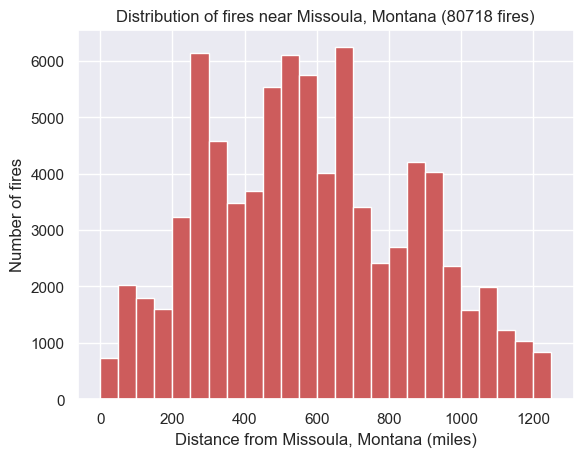

In [6]:
distances = fire_gdf[['OBJECTID', 'distances']]
fig, ax = plt.subplots()
plt.hist(distances['distances'], bins=[x for x in range(0, 1251, 50)], color='indianred')
plt.ylabel('Number of fires')
plt.xlabel('Distance from Missoula, Montana (miles)')
plt.title(f'Distribution of fires near Missoula, Montana ({distances.shape[0]} fires)')
plt.show()

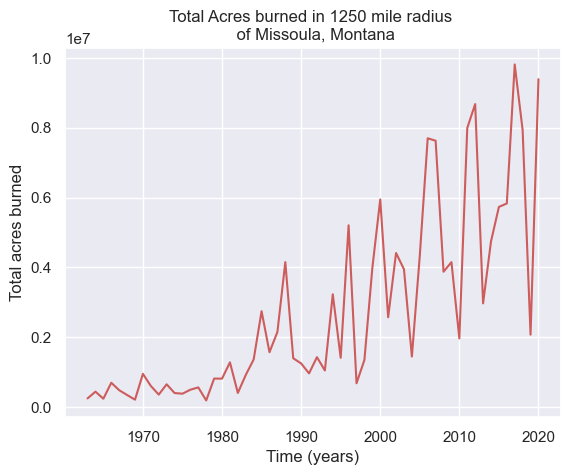

In [7]:
# Plotting acres burned per year by fires near Missoula, Montana
acres_burned_per_year = fire_gdf[['GIS_Acres', 'Fire_Year']].groupby('Fire_Year').sum().reset_index()
fig, ax = plt.subplots()
plt.plot(acres_burned_per_year['Fire_Year'], acres_burned_per_year['GIS_Acres'], color='indianred')
plt.xlabel('Time (years)')
plt.ylabel('Total acres burned')
plt.title('Total Acres burned in 1250 mile radius \n of Missoula, Montana')
plt.show()

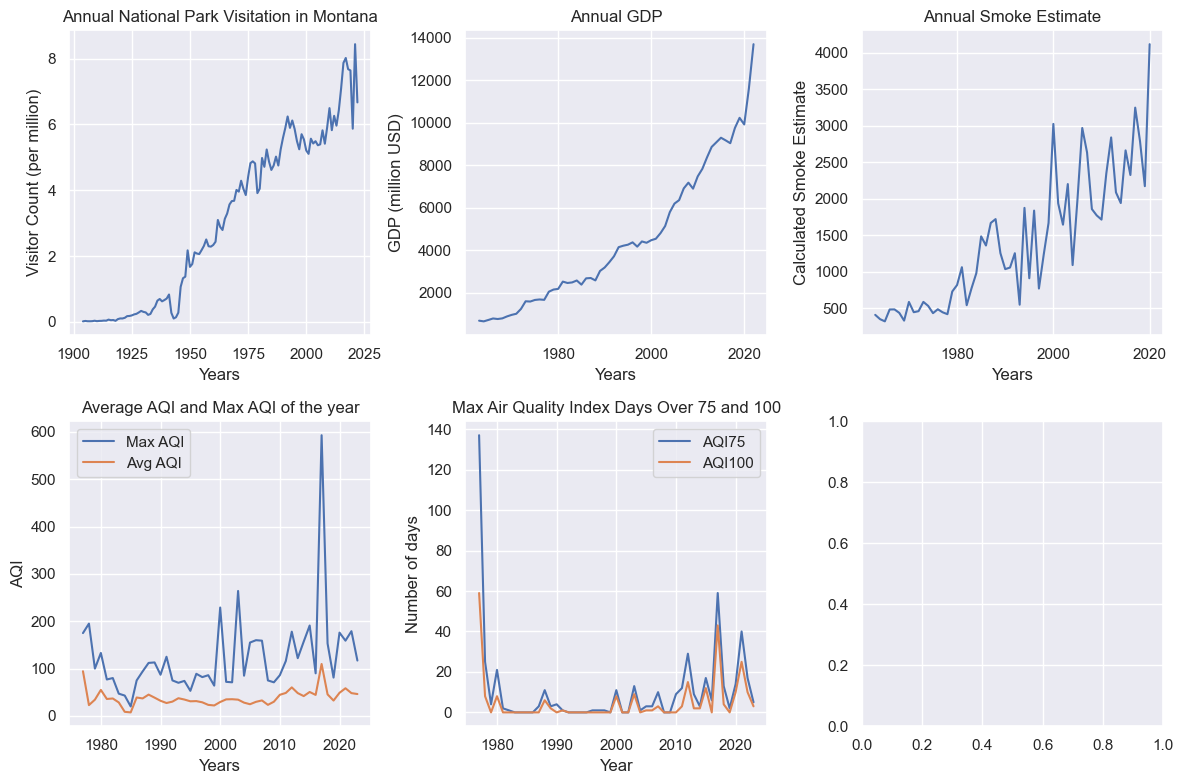

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
ax[0][0].plot(np_years_df['year'], np_years_df['clean_TRV']/(1e6))
ax[0][1].plot(gdp_df['year'], gdp_df['gdp'])
ax[0][2].plot(smoke_estimate_df['year'], smoke_estimate_df['smoke_estimate'])
ax[1][0].plot(aqi_df['year'], aqi_df['max_aqi'], label='Max AQI')
ax[1][0].plot(aqi_df['year'], aqi_df['avg_aqi'], label='Avg AQI')
ax[1][1].plot(aqi_df['year'], aqi_df['aqi75'], label='AQI75')
ax[1][1].plot(aqi_df['year'], aqi_df['aqi100'], label='AQI100')

ax[0][0].set_title("Annual National Park Visitation in Montana")
ax[0][0].set_xlabel("Years")
ax[0][0].set_ylabel("Visitor Count (per million)")

ax[0][1].set_title("Annual GDP")
ax[0][1].set_xlabel("Years")
ax[0][1].set_ylabel("GDP (million USD)")

ax[1][0].set_title("Average AQI and Max AQI of the year")
ax[1][0].set_xlabel("Years")
ax[1][0].set_ylabel("AQI")
ax[1][0].legend()

ax[1][1].set_title("Max Air Quality Index Days Over 75 and 100")
ax[1][1].set_xlabel("Year")
ax[1][1].set_ylabel("Number of days")
ax[1][1].legend()

ax[0][2].set_title("Annual Smoke Estimate")
ax[0][2].set_xlabel("Years")
ax[0][2].set_ylabel("Calculated Smoke Estimate")
plt.tight_layout()
plt.show()


### 2. Data Transformations

The next step is to merge all of the four datasources into a single dataframe that has no missing values so that we can perform further analysis on it.

In [9]:
# Merging into a single dataframe
final_df = pd.merge(np_years_df, gdp_df, on='year', how='outer')
final_df = final_df.merge(aqi_df, on='year', how='outer')
final_df = final_df.merge(smoke_estimate_df, on='year', how='outer')
# Removing years where we do not have data for all four variables
final_df = final_df[final_df[['clean_TRV', 'gdp', 'max_aqi', 'avg_aqi', 'aqi75', 'aqi100', 'smoke_estimate']].notna().all(axis=1)]
# Removing unessential columns
final_df = final_df[['year', 'clean_TRV', 'gdp', 'max_aqi', 'avg_aqi', 'aqi75', 'aqi100', 'smoke_estimate']]
final_df.columns = ['year', 'park_visits', 'gdp', 'max_aqi', 'avg_aqi', 'aqi75', 'aqi100', 'smoke_estimate']
final_df = final_df.reset_index().drop(columns='index')
final_df.head()

,year,park_visits,gdp,max_aqi,avg_aqi,aqi75,aqi100,smoke_estimate
0,1977,4879300.0,1669.4,175.0,94.377778,137.0,59.0,445.964455
1,1978,4815958.0,2051.8,195.0,22.824675,25.0,8.0,420.096792
2,1979,3912887.0,2153.5,100.0,34.330275,4.0,0.0,730.704626
3,1980,4048439.0,2183.6,133.0,54.932961,21.0,8.0,819.499266
4,1981,4980958.0,2526.0,77.0,35.820225,2.0,0.0,1063.877879


#### Splitting the data

Because this is time series data we can't do a shuffled train test split since we want to preserve the order of the data. Instead we will just take the last 10% of the data for our training set.

In [10]:
# Test Train split
train = final_df.iloc[:int(0.9*(len(final_df)))]
test = final_df.iloc[int(0.9*(len(final_df))):]

#### Scaling the data

The next step is to scale the data. This is critical for developing a machine learning model, because we are interested in relative changes and don't want units to alter the relationships. Because scaling methods depend on the distribution of values it is important to look at the histograms.

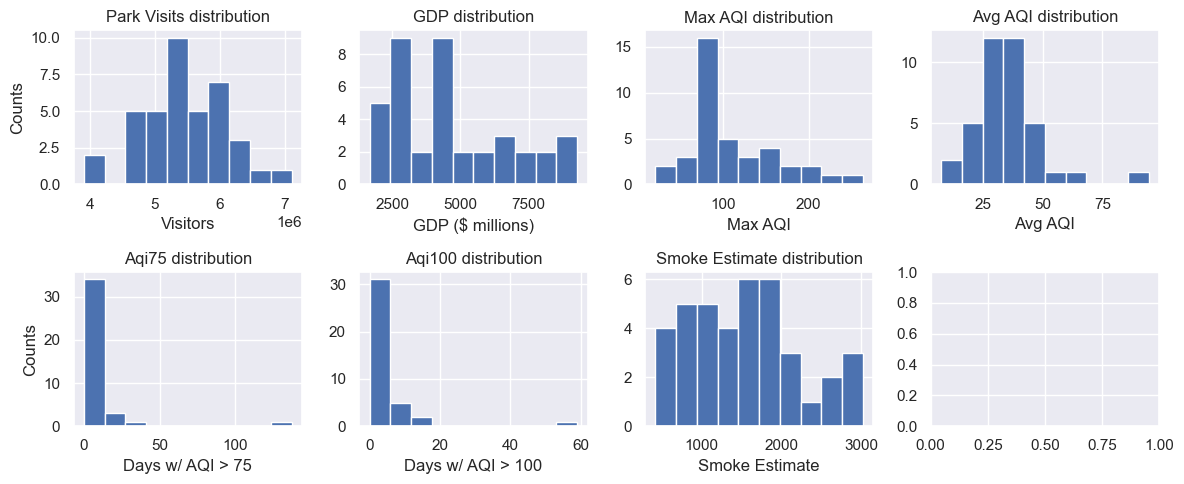

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))
xlabels = ['Visitors', 'GDP ($ millions)', 'Max AQI', 'Avg AQI', 'Days w/ AQI > 75', 'Days w/ AQI > 100', 'Smoke Estimate']
axes = np.hstack([ax[0], ax[1]])
for i in range(len(axes) - 1):
    var = list(train.columns)[i + 1]
    axes[i].hist(train[var])
    axes[i].set_title(f"{snake_to_title_case(var)} distribution")
    axes[0].set_ylabel("Counts")
    axes[4].set_ylabel("Counts")
    axes[i].set_xlabel(xlabels[i])
    plt.tight_layout()
plt.show()

Given that the visitors, aqi and smoke estimate are all about normally distributed we will use the StandardScaler method to scale them. MinMaxScaler will be used for GDP, since this method handles skewed data better.

In [12]:
# Defining scalers
gdp_scaler = MinMaxScaler()
max_aqi_scaler = StandardScaler()
avg_aqi_scaler = StandardScaler()
aqi75_scaler = MinMaxScaler()
aqi100_scaler = MinMaxScaler()
park_visits_scaler = StandardScaler()
smoke_estimate_scaler = StandardScaler()

# Fiting and transforming scalers on train data
gdp_scaled = gdp_scaler.fit_transform(train[['gdp']])
max_aqi_scaled = max_aqi_scaler.fit_transform(train[['max_aqi']])
avg_aqi_scaled = avg_aqi_scaler.fit_transform(train[['avg_aqi']])
aqi75_scaled = aqi75_scaler.fit_transform(train[['aqi75']])
aqi100_scaled = aqi100_scaler.fit_transform(train[['aqi100']])
park_visits_scaled = park_visits_scaler.fit_transform(train[['park_visits']])
smoke_estimate_scaled = smoke_estimate_scaler.fit_transform(train[['smoke_estimate']])

# Transform test data
gdp_test_scaled = gdp_scaler.transform(test[['gdp']])
max_aqi_test_scaled = max_aqi_scaler.transform(test[['max_aqi']])
avg_aqi_test_scaled = avg_aqi_scaler.transform(test[['avg_aqi']])
aqi75_test_scaled = aqi75_scaler.transform(test[['aqi75']])
aqi100_test_scaled = aqi100_scaler.transform(test[['aqi100']])
park_visits_test_scaled = park_visits_scaler.transform(test[['park_visits']])
smoke_estimate_test_scaled = smoke_estimate_scaler.transform(test[['smoke_estimate']])

# Creating scaled dataframes
scaled_train_df = train.copy()
scaled_train_df['gdp'] = gdp_scaled
scaled_train_df['max_aqi'] = max_aqi_scaled
scaled_train_df['avg_aqi'] = avg_aqi_scaled
scaled_train_df['aqi75'] = aqi75_scaled
scaled_train_df['aqi100'] = aqi100_scaled
scaled_train_df['park_visits'] = park_visits_scaled
scaled_train_df['smoke_estimate'] = smoke_estimate_scaled

scaled_test_df = test.copy()
scaled_test_df['gdp'] = gdp_test_scaled
scaled_test_df['max_aqi'] = max_aqi_test_scaled
scaled_test_df['avg_aqi'] = avg_aqi_test_scaled
scaled_test_df['aqi75'] = aqi75_test_scaled
scaled_test_df['aqi100'] = aqi100_test_scaled
scaled_test_df['park_visits'] = park_visits_test_scaled
scaled_test_df['smoke_estimate'] = smoke_estimate_test_scaled

#### Visualizing the scaled data
Now that I have scaled all of the data. I can visualize the outputs for verification.

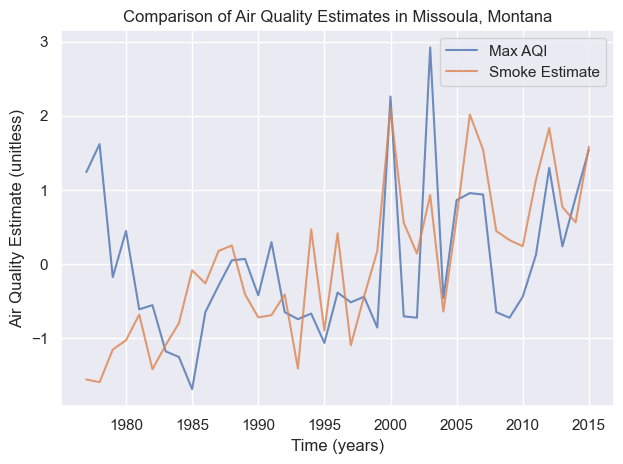

In [13]:
fig, ax = plt.subplots()
plt.plot(scaled_train_df['year'], scaled_train_df['max_aqi'], label='Max AQI', alpha=0.8)
plt.plot(scaled_train_df['year'], scaled_train_df['smoke_estimate'], label='Smoke Estimate', alpha=0.8)
plt.xlabel('Time (years)')
plt.ylabel('Air Quality Estimate (unitless)')
plt.title('Comparison of Air Quality Estimates in Missoula, Montana')
plt.legend()
plt.tight_layout()
plt.show()

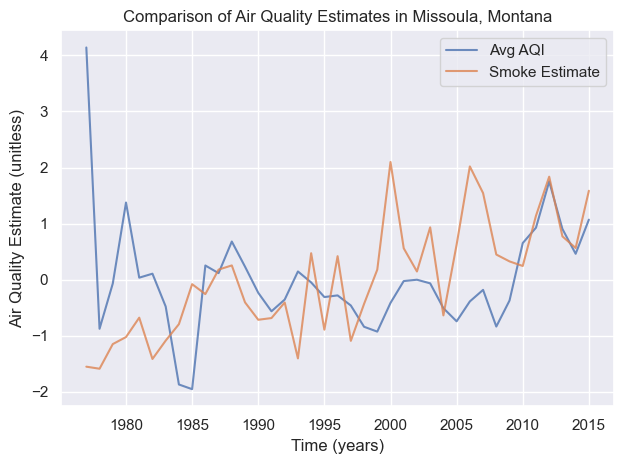

In [14]:
fig, ax = plt.subplots()
plt.plot(scaled_train_df['year'], scaled_train_df['avg_aqi'], label='Avg AQI', alpha=0.8)
plt.plot(scaled_train_df['year'], scaled_train_df['smoke_estimate'], label='Smoke Estimate', alpha=0.8)
plt.xlabel('Time (years)')
plt.ylabel('Air Quality Estimate (unitless)')
plt.title('Comparison of Air Quality Estimates in Missoula, Montana')
plt.legend()
plt.tight_layout()
plt.show()

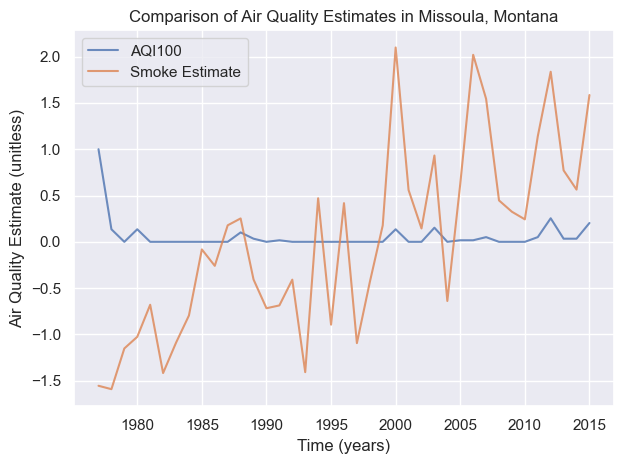

In [15]:
fig, ax = plt.subplots()
plt.plot(scaled_train_df['year'], scaled_train_df['aqi100'], label='AQI100', alpha=0.8)
plt.plot(scaled_train_df['year'], scaled_train_df['smoke_estimate'], label='Smoke Estimate', alpha=0.8)
plt.xlabel('Time (years)')
plt.ylabel('Air Quality Estimate (unitless)')
plt.title('Comparison of Air Quality Estimates in Missoula, Montana')
plt.legend()
plt.tight_layout()
plt.show()

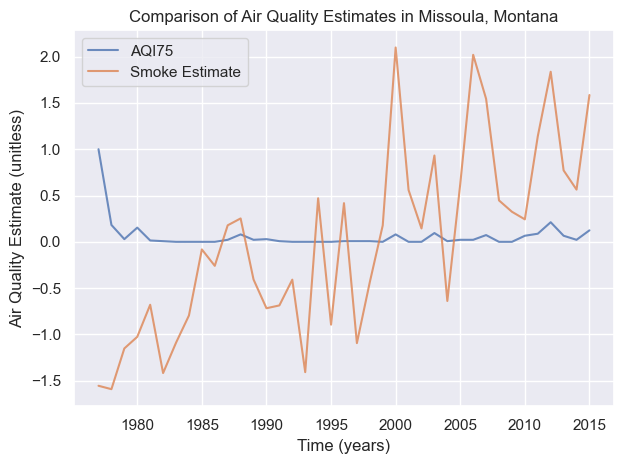

In [16]:
fig, ax = plt.subplots()
plt.plot(scaled_train_df['year'], scaled_train_df['aqi75'], label='AQI75', alpha=0.8)
plt.plot(scaled_train_df['year'], scaled_train_df['smoke_estimate'], label='Smoke Estimate', alpha=0.8)
plt.xlabel('Time (years)')
plt.ylabel('Air Quality Estimate (unitless)')
plt.title('Comparison of Air Quality Estimates in Missoula, Montana')
plt.legend()
plt.tight_layout()
plt.show()

I can also plot all of the scaled variables on a single plot.

In [63]:
def plot_multivariate(df, ax, use_index=True):
    if not use_index:
        df = df.set_index('year')
    for col in list(df.columns):
        ax.plot(df[col], label=snake_to_title_case(col), alpha=0.8)
    plt.legend()
    return ax

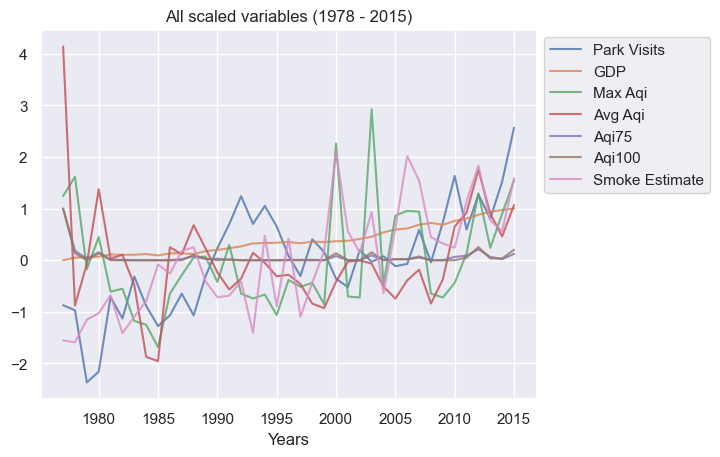

In [64]:
fig, ax = plt.subplots()
plot_multivariate(scaled_train_df, ax, use_index=False)
ax.set_title('All scaled variables (1978 - 2015)')
ax.set_xlabel("Years")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### 3. Correlation Analysis

Now, I will begin my correlation analysis based on the newly scaled training data.

#### Pearson Correlation

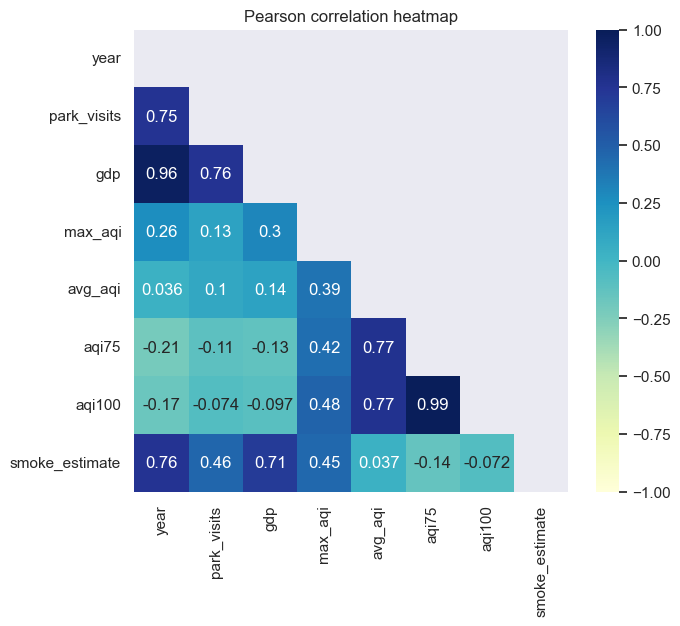

In [18]:
# Computing Correlation matrix
r = scaled_train_df.corr()
fig, ax = plt.subplots(figsize=(7, 6))
with sns.axes_style("white"):
    mask = np.zeros_like(r)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(r, mask=mask, cmap="YlGnBu", vmin=-1, vmax=1, annot=True, ax=ax)
#   ax.add_patch(Rectangle((5, 6), 1, 1, fill=False, edgecolor='red', lw=2.5, clip_on=False))
    ax.set_title("Pearson correlation heatmap")
    plt.show()

#### Rolling-Pearson Correlation and Correlation coefficient

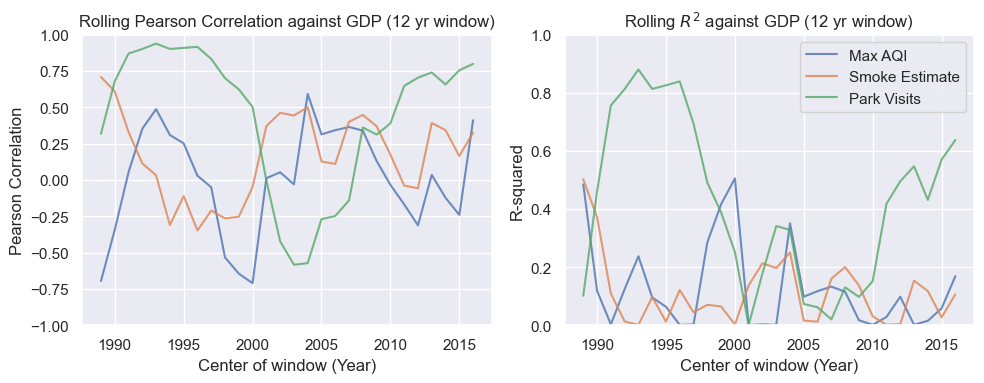

In [19]:
r_window_size = 12
features = ['max_aqi', 'smoke_estimate', 'park_visits']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for feature in features:
    rolling_r = scaled_train_df[feature].rolling(window=r_window_size, center=True).corr(scaled_train_df['gdp']).dropna()
    rolling_r = rolling_r.reset_index()
    rolling_r.columns = ['year', 'r']
    rolling_r['year'] = rolling_r['year'] + int(r_window_size / 2) + final_df['year'].min()
    ax[0].plot(rolling_r['year'], rolling_r['r'], label=snake_to_title_case(feature), alpha=0.8)
    ax[1].plot(rolling_r['year'], rolling_r['r']**2, label=snake_to_title_case(feature),alpha=0.8)
ax[0].set_title(f"Rolling Pearson Correlation against GDP ({r_window_size} yr window)")
ax[1].set_title(f"Rolling $R^2$ against GDP ({r_window_size} yr window)")
ax[1].legend()

ax[0].set_ylabel("Pearson Correlation")
ax[1].set_ylabel("R-squared")
ax[0].set_ylim(-1, 1)
ax[1].set_ylim(0, 1)

ax[0].set_xlabel("Center of window (Year)")
ax[1].set_xlabel("Center of window (Year)")
plt.tight_layout()
plt.show()


#### Time-Lagged Cross Correlation

In [20]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

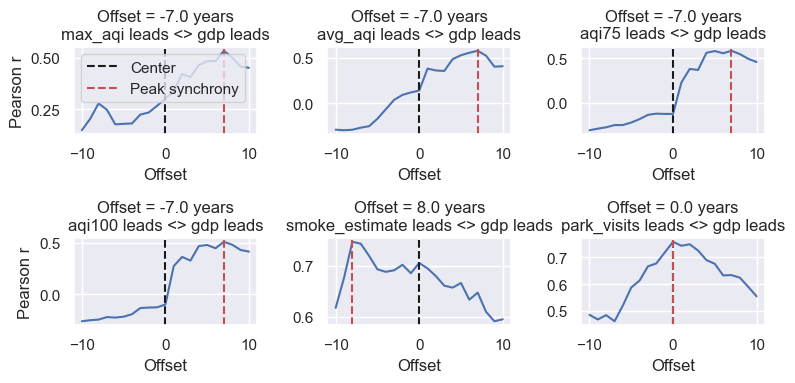

In [21]:
predictors = ['max_aqi', 'avg_aqi', 'aqi75', 'aqi100', 'smoke_estimate', 'park_visits']
response = "gdp"
f,ax=plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
axes = np.hstack([ax[0], ax[1]])
for i, predictor in enumerate(predictors):
    d1 = scaled_train_df[predictor]
    d2 = scaled_train_df[response]
    lag_val = 10
    lags = list(range(-lag_val,lag_val+1))
    rs = [crosscorr(d1,d2, lag) for lag in lags]
    offset = np.floor(len(rs)/2)-np.argmax(rs)
    axes[i].plot(lags, rs)
    axes[i].axvline(0,color='k',linestyle='--',label='Center')
    axes[i].axvline(lags[np.argmax(rs)],color='r',linestyle='--',label='Peak synchrony')
    axes[i].set(title=f'Offset = {offset} years\n{predictor} leads <> {response} leads', xlabel='Offset', ylabel='Pearson r')
    axes[i].set_ylabel('')
    axes[0].legend()
axes[0].set_ylabel('Pearson r')
axes[3].set_ylabel('Pearson r')
plt.tight_layout()
plt.show()

#### Dynamic Time Warping

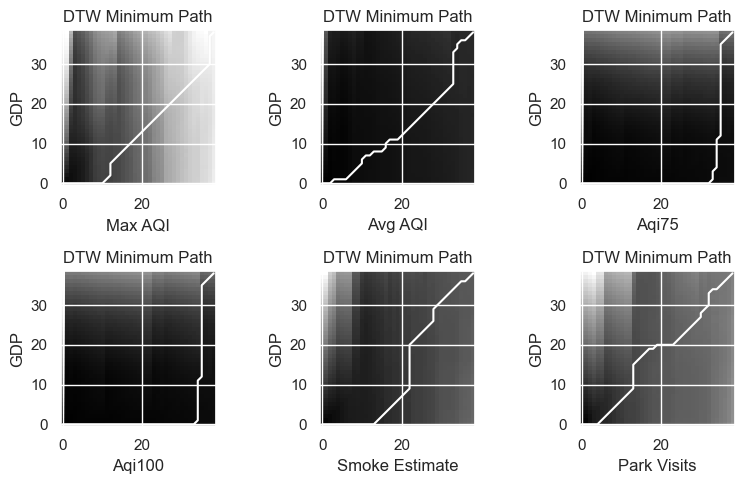

In [180]:
predictors = ['max_aqi', 'avg_aqi', 'aqi75', 'aqi100', 'smoke_estimate', 'park_visits']
response = "gdp"
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
axes = np.hstack([ax[0], ax[1]])
for i, predictor in enumerate(predictors):
    d1 = scaled_train_df[predictor].interpolate().values
    d2 = scaled_train_df[response].interpolate().values
    d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

    axes[i].imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
    axes[i].plot(path[0], path[1], 'w')
    axes[i].set_xlabel(snake_to_title_case(predictor))
    axes[i].set_ylabel(snake_to_title_case(response))
    axes[i].set_title(f'DTW Minimum Path')
plt.tight_layout()
plt.show()

### 4. Time Series Forecasting and Model development

The first step for forecasting the data is to now merge all of the data back together. Bringing the train and test data into a single all_scaled dataframe.

In [23]:
features = ['year', 'max_aqi', 'avg_aqi', 'aqi100', 'aqi75', 'smoke_estimate', 'park_visits']
response = 'gdp'

X_train = scaled_train_df[features]
y_train = scaled_train_df[response]

X_test = scaled_test_df[features]
y_test = scaled_test_df[response]

# All scaled data
all_scaled_df = pd.concat([scaled_train_df, scaled_test_df], axis=0, ignore_index=True)
X_all_scaled = all_scaled_df[features]
y_all_scaled = all_scaled_df[['year', response]]

Next, using statsmodels I can build an Ordinary Least Squares model using all of the defined predictors.

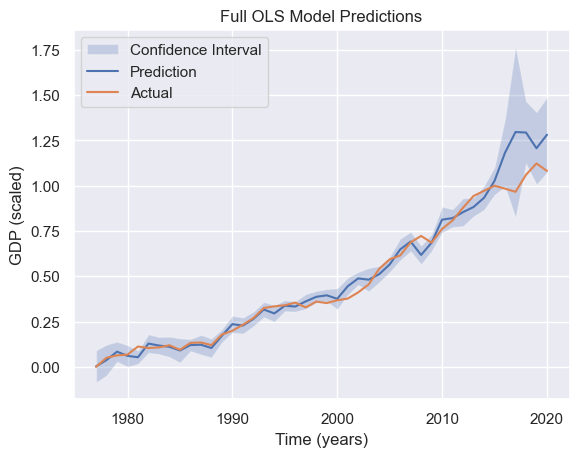

In [28]:
formula = "gdp ~ year * max_aqi + year * avg_aqi + year * aqi75 + year * aqi100 + year * smoke_estimate + year * park_visits"
ols_model = smf.ols(formula=formula, data=scaled_train_df)
result = ols_model.fit()

# Plotting predicted values
# Define values and true values
x_pred = X_all_scaled
y_true = y_all_scaled

# Get prediction mean and intervals
pred_results = result.get_prediction(x_pred)
y_pred = pred_results.predicted_mean
conf_int = pred_results.conf_int()

# Plotting
fig, ax = plt.subplots()
plt.fill_between(x_pred['year'], conf_int[:, 1], conf_int[:, 0], alpha=0.25, label='Confidence Interval')
plt.plot(x_pred.year, y_pred, label='Prediction')
plt.plot(y_true.year, y_true['gdp'], label='Actual')

plt.title(f'Full OLS Model Predictions')
plt.xlabel('Time (years)')
plt.ylabel("GDP (scaled)")
plt.legend(loc='upper left')
plt.show()

In [196]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     129.0
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.47e-19
Time:                        10:21:27   Log-Likelihood:                 75.758
No. Observations:                  39   AIC:                            -123.5
Df Residuals:                      25   BIC:                            -100.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -49.2854      3.237    -15.226      0.000     -55.952     -42.619
year                    0.0249      0.002     15.318      0.000       0.022       0.028
max_aqi                -3.2643      2.314     -1.411      0.171      -8.030       1.502
year:max_aqi            0.0016      0.001      1.410      0.171      -0.001       0.004
avg_aqi                -1.5687      2.662     -0.589      0.561      -7.051       3.914
year:avg_aqi            0.0008      0.001      0.593      0.559      -0.002       0.004
aqi75                  14.1278     82.048      0.172      0.865    -154.853     183.108
year:aqi75             -0.0068      0.041     -0.167      0.869      -0.091       0.078
aqi100                 14.1942     74.279      0.191      0.850    -138.786     167.174
year:aqi100            -0.0075      0.037     -0.202      0.842      -0.084       0.069
smoke_estimate         -8.8954      2.823     -3.151      0.004     -14.709      -3.082
year:smoke_estimate     0.0044      0.001      3.147      0.004       0.002       0.007
park_visits            -4.4157      1.922     -2.298      0.030      -8.373      -0.458
year:park_visits        0.0022      0.001      2.302      0.030       0.000       0.004
==============================================================================
Omnibus:                        3.687   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                2.570
Skew:                           0.366   Prob(JB):                        0.277
Kurtosis:                       4.023   Cond. No.                     4.25e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I can then iterate on this initial full model, by dropping some terms that may be highly collinear and seeing if that improves the AIC score.

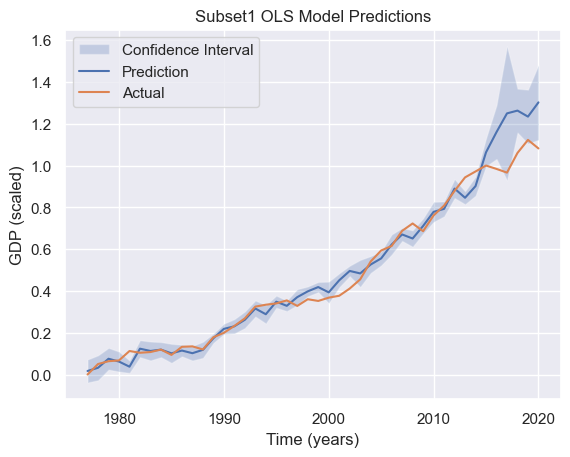

In [27]:
formula = "gdp ~ year * max_aqi + year * smoke_estimate + year * park_visits"
ols_model = smf.ols(formula=formula, data=scaled_train_df)
result = ols_model.fit()

# Plotting predicted values
# Define values and true values
x_pred = X_all_scaled
y_true = y_all_scaled

# Get prediction mean and intervals
pred_results = result.get_prediction(x_pred)
y_pred = pred_results.predicted_mean
conf_int = pred_results.conf_int()

# Plotting
fig, ax = plt.subplots()
plt.fill_between(x_pred['year'], conf_int[:, 1], conf_int[:, 0], alpha=0.25, label='Confidence Interval')
plt.plot(x_pred.year, y_pred, label='Prediction')
plt.plot(y_true.year, y_true['gdp'], label='Actual')

plt.title(f'Subset1 OLS Model Predictions')
plt.xlabel('Time (years)')
plt.ylabel("GDP (scaled)")
plt.legend(loc='upper left')
plt.show()

In [26]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     230.8
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           6.45e-25
Time:                        15:01:17   Log-Likelihood:                 70.910
No. Observations:                  39   AIC:                            -125.8
Df Residuals:                      31   BIC:                            -112.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -49.6762      2.828    -17.564      0.000     -55.444     -43.908
year                    0.0251      0.001     17.687      0.000       0.022       0.028
max_aqi                -0.6329      1.565     -0.404      0.689      -3.826       2.560
year:max_aqi            0.0003      0.001      0.395      0.695      -0.001       0.002
smoke_estimate         -9.0149      2.248     -4.010      0.000     -13.600      -4.430
year:smoke_estimate     0.0045      0.001      4.004      0.000       0.002       0.007
park_visits            -4.8803      1.548     -3.153      0.004      -8.037      -1.724
year:park_visits        0.0025      0.001      3.160      0.004       0.001       0.004
==============================================================================
Omnibus:                        1.149   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.563   Jarque-Bera (JB):                0.459
Skew:                           0.224   Prob(JB):                        0.795
Kurtosis:                       3.287   Cond. No.                     1.12e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

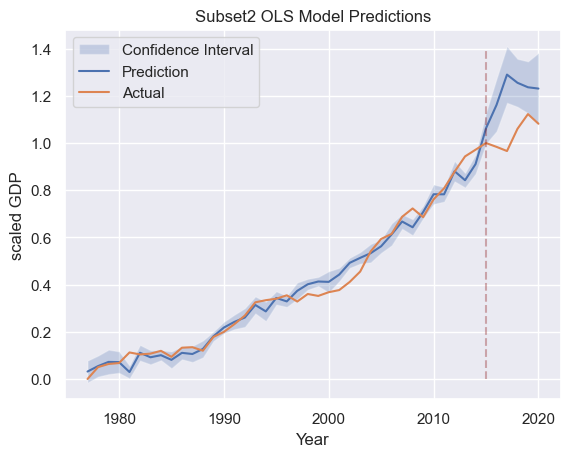

In [29]:
formula = "gdp ~ year * smoke_estimate + year * park_visits"
ols_model = smf.ols(formula=formula, data=scaled_train_df)
result = ols_model.fit()

# Plotting predicted values
# Define values and true values
x_pred = X_all_scaled
y_true = y_all_scaled

# Get prediction mean and intervals
pred_results = result.get_prediction(x_pred)
y_pred = pred_results.predicted_mean
conf_int = pred_results.conf_int()

# Plotting
fig, ax = plt.subplots()
plt.fill_between(x_pred['year'], conf_int[:, 1], conf_int[:, 0], alpha=0.25, label='Confidence Interval')
plt.plot(x_pred.year, y_pred, label='Prediction')
plt.plot(y_true.year, y_true['gdp'], label='Actual')
plt.vlines(x=2015, ymin=0, ymax = 1.4, linestyles='dashed', colors='maroon', alpha=0.3)
plt.title(f'Subset2 OLS Model Predictions')
plt.xlabel('Year')
plt.ylabel("scaled GDP")
plt.legend(loc='upper left')
plt.show()

In [30]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     319.8
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           6.07e-27
Time:                        15:02:08   Log-Likelihood:                 69.519
No. Observations:                  39   AIC:                            -127.0
Df Residuals:                      33   BIC:                            -117.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -49.3922      2.755    -17.928      0.000     -54.997     -43.787
year                    0.0249      0.001     18.055      0.000       0.022       0.028
smoke_estimate         -7.3080      1.949     -3.750      0.001     -11.272      -3.343
year:smoke_estimate     0.0037      0.001      3.745      0.001       0.002       0.006
park_visits            -5.3086      1.490     -3.563      0.001      -8.340      -2.277
year:park_visits        0.0027      0.001      3.572      0.001       0.001       0.004
==============================================================================
Omnibus:                        1.024   Durbin-Watson:                   1.258
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                0.562
Skew:                           0.292   Prob(JB):                        0.755
Kurtosis:                       3.071   Cond. No.                     9.72e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

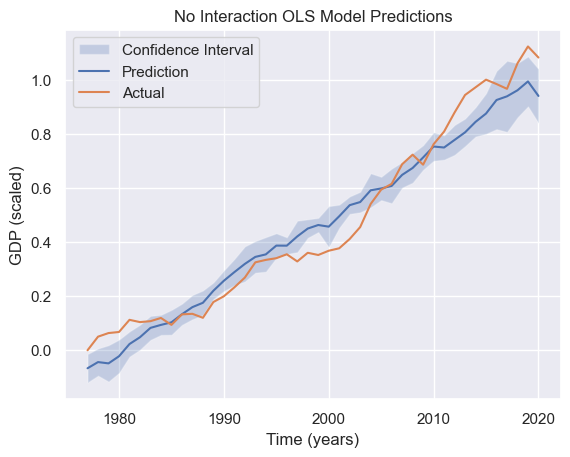

In [31]:
formula = "gdp ~ smoke_estimate + park_visits + year"
ols_model = smf.ols(formula=formula, data=scaled_train_df)
result = ols_model.fit()

# Plotting predicted values
# Define values and true values
x_pred = X_all_scaled
y_true = y_all_scaled

# Get prediction mean and intervals
pred_results = result.get_prediction(x_pred)
y_pred = pred_results.predicted_mean
conf_int = pred_results.conf_int()

# Plotting
fig, ax = plt.subplots()
plt.fill_between(x_pred['year'], conf_int[:, 1], conf_int[:, 0], alpha=0.25, label='Confidence Interval')
plt.plot(x_pred.year, y_pred, label='Prediction')
plt.plot(y_true.year, y_true['gdp'], label='Actual')

plt.title(f'No Interaction OLS Model Predictions')
plt.xlabel('Time (years)')
plt.ylabel("GDP (scaled)")
plt.legend(loc='upper left')
plt.show()

In [32]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     164.3
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.11e-20
Time:                        15:02:41   Log-Likelihood:                 46.358
No. Observations:                  39   AIC:                            -84.72
Df Residuals:                      35   BIC:                            -78.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -47.7758      4.730    -10.101      0.000     -57.377     -38.174
smoke_estimate    -0.0111      0.020     -0.563      0.577      -0.051       0.029
park_visits        0.0172      0.020      0.876      0.387      -0.023       0.057
year               0.0241      0.002     10.184      0.000       0.019       0.029
==============================================================================
Omnibus:                        3.897   Durbin-Watson:                   0.157
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                1.876
Skew:                           0.208   Prob(JB):                        0.391
Kurtosis:                       2.009   Cond. No.                     7.58e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Forecasting AQI, Smoke Estimate and Park Visits
The next step is to forecast the necessary variables so that I can predict GDP. I will utilize Ridge regression and Grid search to do this

In [ ]:
# Scaling the years
final_df['year_scaled'] = final_df['year'] - 1977
# Get best polynomial regressors for features
best_estimators = {}
for feature in ['max_aqi', 'smoke_estimate', 'park_visits']:
    X_train = final_df['year_scaled'].to_numpy().reshape(-1, 1)
    y_train = final_df[feature]
    param_grid = [
        {'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
    ]
    pipeline = Pipeline(steps=[('poly', PolynomialFeatures()), ('ridge', Ridge())])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                            scoring='neg_mean_squared_error',
                            return_train_score=True)
    result = grid_search.fit(X_train, y_train)
    estimator = result.best_estimator_
    params = result.best_params_
    best_estimators[feature] = (estimator, params)

I can then look at which hyperparameters (polynomial degree) had performed best. Shown below we can see that polynomial degrees 2, 1, and 3 were best for max_aqi, smoke estimate, and park visits.

In [37]:
best_estimators

{'max_aqi': (Pipeline(steps=[('poly', PolynomialFeatures()), ('ridge', Ridge())]),
  {'poly__degree': 2}),
 'smoke_estimate': (Pipeline(steps=[('poly', PolynomialFeatures(degree=1)), ('ridge', Ridge())]),
  {'poly__degree': 1}),
 'park_visits': (Pipeline(steps=[('poly', PolynomialFeatures(degree=3)), ('ridge', Ridge())]),
  {'poly__degree': 3})}

Taking these estimators I can then predict the values of the two variables I will use in my forecasting model.

In [38]:
num_forecast_years = 10
year_start = final_df['year_scaled'].max() + 1
# year_start = 1
X_forecast = np.array(list(range(year_start, year_start + num_forecast_years, 1))).reshape(-1, 1)
# Predict next ten years
forecast_df = pd.DataFrame({'year': X_forecast[:, 0]})
for feature in ['smoke_estimate', 'park_visits']:
    y_forecast = best_estimators[feature][0].predict(X_forecast)
    forecast_df[feature] = y_forecast

# Rescale features
smoke_forecast_scale = smoke_estimate_scaler.transform(forecast_df[['smoke_estimate']])
park_visits_forecast_scale = park_visits_scaler.transform(forecast_df[['park_visits']])
scaled_forecast_array = np.hstack([smoke_forecast_scale, park_visits_forecast_scale])

scaled_forecast_df = pd.DataFrame(scaled_forecast_array)
scaled_forecast_df.columns = ['smoke_estimate', 'park_visits']
scaled_forecast_df.insert(0, 'year', forecast_df['year'] + 1977)

### Forecasting GDP
Finally I can forecast the GDP using OLS.

In [42]:
# Concatenating all the data 
full_scaled_df = pd.concat([all_scaled_df, scaled_forecast_df], axis=0)

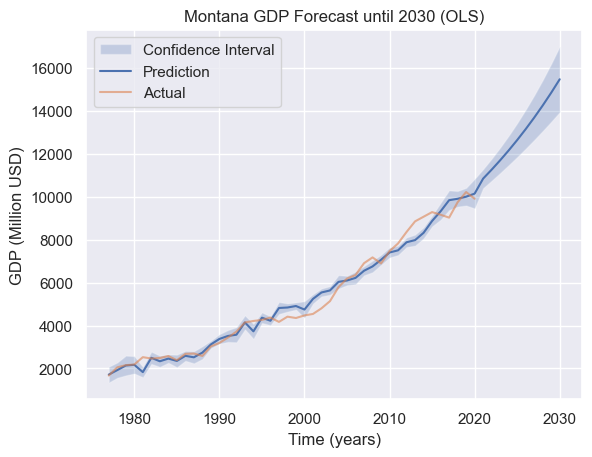

In [43]:
formula = "gdp ~ smoke_estimate * year + park_visits * year"
ols_model = smf.ols(formula=formula, data=all_scaled_df)
result = ols_model.fit()

# Plotting predicted values
# Define values and true values
x_pred = X_all_scaled.copy()
y_true = y_all_scaled.copy()
# Forecast values
X_forecast = full_scaled_df[features]

# Get prediction mean and intervals
pred_results = result.get_prediction(X_forecast)
y_pred = pred_results.predicted_mean
conf_int = pred_results.conf_int()

# Rescale gdp
y_true['gdp'] = gdp_scaler.inverse_transform(y_true[['gdp']])

y_pred = pd.DataFrame({"gdp": y_pred})
y_pred['gdp'] = gdp_scaler.inverse_transform(y_pred[['gdp']])
y_pred = y_pred['gdp'].to_numpy()

# lower bound
lower_bound = pd.DataFrame({"gdp": conf_int[:, 1]})
lower_bound['park_visits'] = np.zeros(len(lower_bound))
lower_bound['gdp'] = gdp_scaler.inverse_transform(lower_bound[['gdp']])
lower_bound = lower_bound['gdp'].to_numpy()

# Upper bound
upper_bound = pd.DataFrame({"gdp": conf_int[:, 0]})
upper_bound['park_visits'] = np.zeros(len(upper_bound))
upper_bound['gdp'] = gdp_scaler.inverse_transform(upper_bound[['gdp']])
upper_bound = upper_bound['gdp'].to_numpy()

plt.fill_between(X_forecast['year'], lower_bound, upper_bound, alpha=0.25, label='Confidence Interval')
plt.plot(X_forecast.year, y_pred, label='Prediction')
plt.plot(y_true.year, y_true['gdp'], label='Actual', alpha=0.6)
plt.title("Montana GDP Forecast until 2030 (OLS)")
plt.xlabel('Time (years)')
plt.ylabel("GDP (Million USD)")
plt.legend(loc='upper left')
plt.show()

Finally we can see the result of the forecasting models fit as well as the p-values for statistical testing.

In [44]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     350.2
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.10e-30
Time:                        15:09:37   Log-Likelihood:                 69.695
No. Observations:                  44   AIC:                            -127.4
Df Residuals:                      38   BIC:                            -116.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -52.8308      3.073    -17.190      0.000     -59.052     -46.609
smoke_estimate         -5.2859      1.374     -3.847      0.000      -8.068      -2.504
year                    0.0266      0.002     17.311      0.000       0.024       0.030
smoke_estimate:year     0.0026      0.001      3.839      0.000       0.001       0.004
park_visits            -3.1188      1.050     -2.970      0.005      -5.244      -0.993
park_visits:year        0.0016      0.001      2.984      0.005       0.001       0.003
==============================================================================
Omnibus:                        0.213   Durbin-Watson:                   0.877
Prob(Omnibus):                  0.899   Jarque-Bera (JB):                0.013
Skew:                          -0.043   Prob(JB):                        0.993
Kurtosis:                       3.000   Cond. No.                     1.31e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [214]:
result.pvalues

Intercept              1.626349e-19
smoke_estimate         4.439242e-04
year                   1.282926e-19
smoke_estimate:year    4.545031e-04
park_visits            5.131649e-03
park_visits:year       4.953280e-03
dtype: float64

### 5. Stats models regressors
Finally I will generate some stats models regression models to visualize the best estimators and their confidence intervals

In [49]:
# Defining a polynomial function for statsmodels regressions
def poly(x, degree):
    return np.vander(x, degree + 1, increasing=True)[:, 1:]

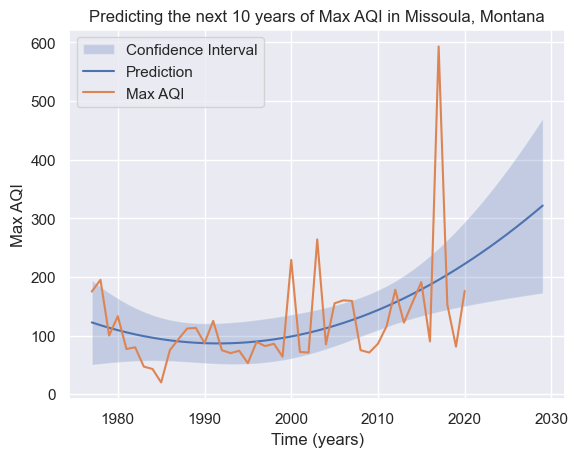

In [50]:
feature = 'max_aqi'
num_forecast_years = 10

df = final_df[['year', feature]]
df = sm.add_constant(df)
model = f"{feature} ~ poly(year, 2)"
result = smf.ols(formula=model, data=df).fit()

x_pred = pd.DataFrame({'year':list(range(df['year'].min(), df['year'].max() + num_forecast_years, 1))})
pred_results = result.get_prediction(x_pred)

y_pred = pred_results.predicted_mean
conf_int = pred_results.conf_int()

feature_title = snake_to_title_case(feature)
fig, ax = plt.subplots()
plt.fill_between(x_pred['year'], conf_int[:, 1], conf_int[:, 0], alpha=0.25, label='Confidence Interval')
plt.plot(x_pred, y_pred, label='Prediction')
plt.plot(df.year, df[feature], label=feature_title)
plt.title(f'Predicting the next {num_forecast_years} years of Max AQI in Missoula, Montana')
plt.xlabel('Time (years)')
plt.ylabel(feature_title)
plt.legend(loc='upper left')
plt.show()

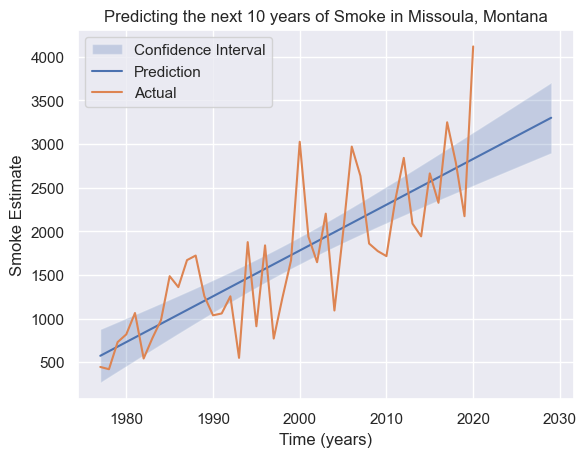

In [51]:
feature = 'smoke_estimate'
num_forecast_years = 10

df = final_df[['year', feature]]
df = sm.add_constant(df)
model = f"{feature} ~ poly(year, 1)"
result = smf.ols(formula=model, data=df).fit()


x_pred = pd.DataFrame({'year':list(range(df['year'].min(), df['year'].max() + num_forecast_years, 1))})
pred_results = result.get_prediction(x_pred)

y_pred = pred_results.predicted_mean
conf_int = pred_results.conf_int()

feature_title = feature.replace("_", " ").title()
fig, ax = plt.subplots()
plt.fill_between(x_pred['year'], conf_int[:, 1], conf_int[:, 0], alpha=0.25, label='Confidence Interval')
plt.plot(x_pred, y_pred, label='Prediction')
plt.plot(df.year, df[feature], label='Actual')
plt.title(f'Predicting the next {num_forecast_years} years of Smoke in Missoula, Montana')
plt.xlabel('Time (years)')
plt.ylabel(feature_title)
plt.legend(loc='upper left')
plt.show()

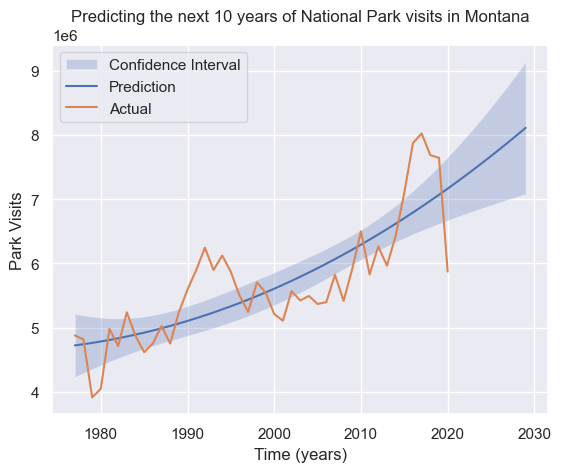

In [52]:
feature = 'park_visits'
num_forecast_years = 10

df = final_df[['year', feature]]
df = sm.add_constant(df)
model = f"{feature} ~ poly(year, 3)"
result = smf.ols(formula=model, data=df).fit()

x_pred = pd.DataFrame({'year':list(range(df['year'].min(), df['year'].max() + num_forecast_years, 1))})
pred_results = result.get_prediction(x_pred)

y_pred = pred_results.predicted_mean
conf_int = pred_results.conf_int()

feature_title = feature.replace("_", " ").title()
fig, ax = plt.subplots()
plt.fill_between(x_pred['year'], conf_int[:, 1], conf_int[:, 0], alpha=0.25, label='Confidence Interval')
plt.plot(x_pred, y_pred, label='Prediction')
plt.plot(df.year, df[feature], label='Actual')
plt.title(f'Predicting the next {num_forecast_years} years of National Park visits in Montana')
plt.xlabel('Time (years)')
plt.ylabel(feature_title)
plt.legend(loc='upper left')
plt.show()